In [1]:
import logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

import numpy as np
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import torch
from ivis import Ivis
import matplotlib.pyplot as plt
from time import perf_counter

## Prepare Dataset

In [2]:
train = pd.read_csv('/workspace/PlayNet/handball_X_train.csv')
train_y = pd.read_csv('/workspace/PlayNet/handball_y_train.csv')
train_states = train_y.copy()
train_states.head()

#play
0  time_out
1  time_out
2  time_out
3  time_out
4  time_out

In [3]:
# creating instance of labelencoder
labelencoder = LabelEncoder()

train_states['#play'] = labelencoder.fit_transform(train_states['#play'])

# passing bridge-types-cat column (label encoded values of bridge_types)
#enc_df = pd.DataFrame(enc.fit_transform(df[['#play']]).toarray())

In [4]:
X = train.values[:train.shape[0], :]
y = train_states.values[:train_states.shape[0], :]

print(X.shape)

(702382, 66)


## Train Model

In [5]:
model = Ivis(n_epochs_without_progress=2, k=50, embedding_dims=30)
embeddings = model.fit(X, y)

Building KNN index


100%|██████████| 702382/702382 [00:03<00:00, 214981.45it/s]


Extracting KNN neighbours


100%|██████████| 702382/702382 [00:22<00:00, 31923.46it/s]


Training neural network
Epoch 1/1000
5488/5488 [==============================] - 23s 4ms/step - loss: 0.3395 - stacked_triplets_loss: 0.1200 - supervised_loss: 0.5589
Epoch 2/1000
5488/5488 [==============================] - 21s 4ms/step - loss: 0.2519 - stacked_triplets_loss: 0.0530 - supervised_loss: 0.4507
Epoch 3/1000
5488/5488 [==============================] - 21s 4ms/step - loss: 0.2296 - stacked_triplets_loss: 0.0422 - supervised_loss: 0.4170
Epoch 4/1000
5488/5488 [==============================] - 21s 4ms/step - loss: 0.2157 - stacked_triplets_loss: 0.0375 - supervised_loss: 0.3940
Epoch 5/1000
5488/5488 [==============================] - 20s 4ms/step - loss: 0.2066 - stacked_triplets_loss: 0.0338 - supervised_loss: 0.3794
Epoch 6/1000
5488/5488 [==============================] - 21s 4ms/step - loss: 0.1993 - stacked_triplets_loss: 0.0310 - supervised_loss: 0.3677
Epoch 7/1000
5488/5488 [==============================] - 21s 4ms/step - loss: 0.1940 - stacked_triplets_loss: 0

In [6]:
embeddings = model.transform(X)

5488/5488 [==============================] - 4s 794us/step


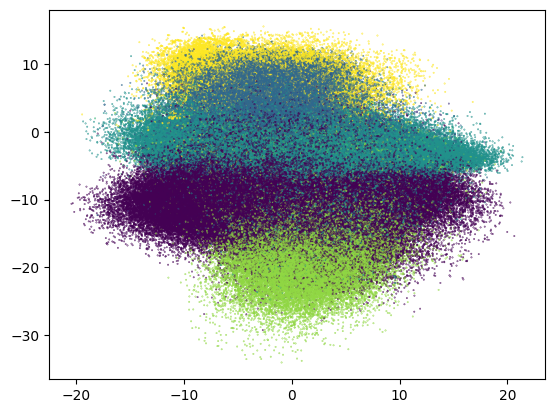

In [7]:
plt.scatter(embeddings[:, 0], embeddings[:, 1], s=0.1, c=y)

In [8]:
c = ['k_{0}'.format(s) for s in range(30)]

#train_data = pd.read_csv('embedding.csv', header=None, names=c)

label = 'state'
train_data = pd.DataFrame(embeddings)
train_data[label] = train_y['#play']
print(train_data.head())
print(train_data.describe())

time_limit = 60*60*1
metric = 'accuracy'

cst_par = {
    'NN_TORCH': {'num_epochs': 4, 'learning_rate': 0.02, 'epochs_wo_improve': 2},
    'GBM': {'num_boost_round': 10},
    'RF': [        
        {'criterion': 'entropy', 'max_depth': 10, 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}
    ],
    'XT': [
        {'criterion': 'gini', 'max_depth': 12, 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}},
    ],
    'KNN': {},
}

predictor = TabularPredictor(label, eval_metric=metric).fit(
    train_data, 
    time_limit=time_limit, 
    presets='medium_quality',
    hyperparameters=cst_par
)

           0         1         2         3         4         5         6  \
0  -9.426482  6.469093  0.799382 -1.579940 -5.096175 -7.090836  4.183897   
1 -10.524791  3.266585  0.085231 -1.009964 -3.674047 -9.869472  1.885840   
2 -11.258952  0.227292  1.675750 -0.985379 -3.910883 -9.663142  0.416616   
3 -11.142485  0.423062  1.579018 -1.025147 -3.802171 -9.550181  0.645586   
4 -10.119455  5.721243 -1.939614 -1.488667 -3.335319 -9.640445  4.086872   

          7         8         9  ...        21        22        23        24  \
0 -0.660246 -2.558493  1.899759  ...  1.215706 -9.067262  0.892936 -4.249401   
1 -1.487294  0.870523  2.616523  ...  1.850730 -5.213078 -4.112883 -2.245088   
2 -0.896651  0.391344  2.535990  ...  1.696528 -5.211050 -5.315310 -4.531416   
3 -0.971606  0.436502  2.460358  ...  1.707391 -5.428711 -5.327046 -4.812799   
4 -2.601946  2.825134  3.392877  ...  1.603420 -2.926069 -2.708605  1.553156   

         25        26        27        28        29     state 

No path specified. Models will be saved in: "AutogluonModels/ag-20230506_220857/"
Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "AutogluonModels/ag-20230506_220857/"
AutoGluon Version:  0.7.0
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #154-Ubuntu SMP Thu Jan 5 17:03:22 UTC 2023
Train Data Rows:    702382
Train Data Columns: 30
Label Column: state
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	7 unique label values:  ['time_out', 'left_transition', 'left_attack', 'right_transition', 'right_attack', 'left_penal', 'right_penal']
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])


                  0              1              2              3   \
count  702382.000000  702382.000000  702382.000000  702382.000000   
mean       -0.094554      -4.999213       0.144706      -0.429859   
std         5.735909       6.621724       5.659734       1.944466   
min       -20.455141     -34.030224     -23.991270      -9.035716   
25%        -4.062662      -9.263493      -3.754933      -1.742441   
50%        -0.238526      -4.559635      -0.002115      -0.364476   
75%         3.712097      -1.657394       3.975662       0.924587   
max        21.388809      15.526931      22.222321       7.390731   

                  4              5              6              7   \
count  702382.000000  702382.000000  702382.000000  702382.000000   
mean       -0.268945      -1.595790       0.181301       0.558892   
std         5.190844       5.018023       5.101116       2.072625   
min       -19.536871     -21.338089     -18.155590      -6.505472   
25%        -3.827367      -5.0957

Train Data Class Count: 7
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    220640.46 MB
	Train Data (Original)  Memory Usage: 84.29 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 30 | ['0', '1', '2', '3', '4', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('float', []) : 30 | ['0', '1', '2', '3', '4', ...]
	2.2s = Fit runtime
	30 features in original data used to generate 30 features in processed data.
	Train Data (Processed) Memory Usage: 84.29 MB 

## Test

In [9]:

#test_data = pd.read_csv('embedding_test.csv', header=None, names=c)
#test_data_umap = pd.read_csv('embedding_test_u.csv', header=None, names=c)

test = pd.read_csv('/workspace/PlayNet/handball_X_test.csv')
y_test = pd.read_csv('/workspace/PlayNet/handball_y_test.csv')['#play']

#X = train.values[:train.shape[0], :]
#y = train_states.values[:train_states.shape[0], :]

test_data_ivis = model.transform(test.values)

y_pred = predictor.predict(pd.DataFrame(test_data_ivis))
#y_test = TabularDataset('y_pred_test.csv')

perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True, detailed_report=True)

test_df = pd.DataFrame(test_data_ivis)
test_df['state'] = y_test
lead = predictor.leaderboard(test_df, extra_info=True, extra_metrics=['accuracy', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted', 'f1_macro', 'f1_weighted'], silent=True)

lead.to_csv('lead.csv', index=False)

2352/2352 [==============================] - 2s 846us/step


Evaluation: accuracy on test data: 0.9109799283773279
Evaluations on test data:
{
    "accuracy": 0.9109799283773279,
    "balanced_accuracy": 0.6906472684485513,
    "mcc": 0.8721742075515444
}
Detailed (per-class) classification report:
{
    "left_attack": {
        "precision": 0.9320173407191952,
        "recall": 0.9627308391541479,
        "f1-score": 0.9471251600271103,
        "support": 104510
    },
    "left_penal": {
        "precision": 0.46392552366175327,
        "recall": 0.23853211009174313,
        "f1-score": 0.3150684931506849,
        "support": 2507
    },
    "left_transition": {
        "precision": 0.8325834625127604,
        "recall": 0.7657081261518134,
        "f1-score": 0.7977467033763224,
        "support": 28759
    },
    "right_attack": {
        "precision": 0.9309607046836271,
        "recall": 0.969153442711135,
        "f1-score": 0.9496732322213209,
        "support": 118976
    },
    "right_penal": {
        "precision": 0.3552758954501452,
   

In [10]:
print('\\midrule')

names = {
    'KNeighbors': 'KNN \cite{cover1967nearest}',
    'LightGBM': 'LigthGBM \cite{ke2017lightgbm}',
    'RandomForestEntr': 'RandomForest \cite{ho1995random}',
    'ExtraTreesGini': 'ExtraTrees \cite{geurts2006extremely}',
    'NeuralNetTorch': 'NN \cite{taud2018multilayer}',
    'WeightedEnsemble_L2': 'Ensemble \cite{wolpert1992stacked}'
}

first = True
for m in predictor.get_model_names():
    #print(m)
    y_pred = predictor.predict(pd.DataFrame(test_data_ivis), model=m)

    perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True, detailed_report=True, silent=True)

    if first:
        print('\\multirow{6}{*}{IVIS  \cite{szubert2019structure}} & ' 
            + names[m] + ' & ' 
            + "{:.1f}".format(round(perf['classification_report']['accuracy']*100,1)) + '\\%  & '
            + "{:.1f}".format(round(perf['classification_report']['weighted avg']['precision']*100,1)) +'\\% & '
            + "{:.1f}".format(round(perf['classification_report']['macro avg']['precision']*100,1)) +'\\% & '
            + "{:.1f}".format(round(perf['classification_report']['weighted avg']['recall']*100,1)) + '\\% & '
            + "{:.1f}".format(round(perf['classification_report']['macro avg']['recall']*100,1)) + '\\%  & '
            + "{:.1f}".format(round(perf['classification_report']['weighted avg']['f1-score']*100,1)) + '\\% & '
            + "{:.1f}".format(round(perf['classification_report']['macro avg']['f1-score']*100,1)) + '\\% \\\\')
        first = False
    else:
        print('\t& ' + names[m] + ' & ' 
            + "{:.1f}".format(round(perf['classification_report']['accuracy']*100,1)) + '\\%  & '
            + "{:.1f}".format(round(perf['classification_report']['weighted avg']['precision']*100,1)) +'\\% & '
            + "{:.1f}".format(round(perf['classification_report']['macro avg']['precision']*100,1)) +'\\% & '
            + "{:.1f}".format(round(perf['classification_report']['weighted avg']['recall']*100,1)) + '\\% & '
            + "{:.1f}".format(round(perf['classification_report']['macro avg']['recall']*100,1)) + '\\%  & '
            + "{:.1f}".format(round(perf['classification_report']['weighted avg']['f1-score']*100,1)) + '\\% & '
            + "{:.1f}".format(round(perf['classification_report']['macro avg']['f1-score']*100,1)) + '\\% \\\\')


\midrule
\multirow{6}{*}{IVIS  \cite{szubert2019structure}} & KNN \cite{cover1967nearest} & 90.8\%  & 90.3\% & 74.2\% & 90.8\% & 69.3\%  & 90.4\% & 71.3\% \\
	& LigthGBM \cite{ke2017lightgbm} & 90.9\%  & 90.6\% & 77.3\% & 90.9\% & 67.6\%  & 90.3\% & 71.3\% \\
	& RandomForest \cite{ho1995random} & 91.7\%  & 91.0\% & 77.8\% & 91.7\% & 65.9\%  & 91.1\% & 68.1\% \\
	& ExtraTrees \cite{geurts2006extremely} & 90.4\%  & 90.4\% & 91.6\% & 90.4\% & 60.7\%  & 89.3\% & 63.7\% \\
	& NN \cite{taud2018multilayer} & 90.9\%  & 90.6\% & 73.5\% & 90.9\% & 69.6\%  & 90.6\% & 71.3\% \\
	& Ensemble \cite{wolpert1992stacked} & 91.1\%  & 90.6\% & 75.5\% & 91.1\% & 69.1\%  & 90.7\% & 71.5\% \\


### Benchmark

In [11]:
test_embed = pd.read_csv('/workspace/PlayNet/handball_X_test.csv')

model.set_params(verbose=0)

# Start the stopwatch / counter
ivis_start = perf_counter()

for index, row in test_embed.iterrows():
    #res = model.transform(np.array([row.values,]))
    res = model.encoder_(np.array([row.values,]), training=False).numpy()

ivis_stop = perf_counter()

In [12]:
print("Elapsed time:", ivis_stop, ivis_start)
print("Tested ", test_embed.shape[0], " elements") 
print("Elapsed time in seconds:", ivis_stop-ivis_start)
print("Perf average per element: ", (ivis_stop-ivis_start)*1000/test_embed.shape[0], " ms")

Elapsed time: 8920489.6230601 8919778.003336882
Tested  301022  elements
Elapsed time in seconds: 711.6197232175618
Perf average per element:  2.364012342013414  ms


In [13]:
import tensorflow as tf
from tensorflow.compat.v1.profiler import Profiler
print('TensorFlow:', tf.__version__)

forward_pass = tf.function(
    model.encoder_.call,
    input_signature=[tf.TensorSpec(shape=(1,) + model.encoder_.input_shape[1:])])

profiler = Profiler(graph=forward_pass.get_concrete_function().graph)
pro=profiler.profile_graph(options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation())

# The //2 is necessary since `profile` counts multiply and accumulate
# as two flops, here we report the total number of multiply accumulate ops
flops = pro.total_float_ops // 2
print('Flops: {:,}'.format(flops))

TensorFlow: 2.11.0
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Flops: 45,263
=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behi

In [29]:
avg_time_ivis = (ivis_stop-ivis_start)*1000/test_embed.shape[0]
norm = 16.85 / 1.9074363765962354
norm_ivis = avg_time_ivis * norm

gflops_ivis = flops/(norm_ivis /1000)/1e9

print("IVIS (GPU) \cite{szubert2019structure} & ", 
      "{:.3f}M".format(round(model.encoder_.count_params()/1e6,3)), 
      " & {:.3f}".format(round(gflops_ivis,3)),
      " & ", 
      "{:.2f}".format(round(norm_ivis,2)),
      " \\\\")

IVIS (GPU) \cite{szubert2019structure} &  0.045M  & 0.002  &  20.88  \\


In [15]:
print(model.encoder_.count_params())

45470
